# Timing backtest with learning

In [1]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from pathlib import Path
import os 
import subprocess
from IPython.display import Image, display

from skfin.plot import line, bar

In previous sections, we studied the predictability of industry and stock returns in a long-short "cash-neutral" setting. In this section, we shift to the predictability of a single asset (ie. the "market" as the S\&P 500 US index).

## Timing the market

To evaluate the out-of-sample predictability of a variable, Welch-Goyal (2008) compare two regressions:

- conditional regression (based on the predictor)
- unconditional regression (based on a rolling mean)
- the comparison between the two regression provides a test of whether the predictor has any value.


Intuition

- “low" prices relative to dividends forecast higher subsequent returns
- other ratios (earnings, book value, moving average of past prices instead of dividends) should also work
- expected returns vary over the business cycle and higher risk premium required to get people to hold stocks at the bottom of a recession: dividend-price ratios can be interpreted a state-variable capturing business cycle risk

Critical view

- are the in-sample results robust out-of-sample?


Data

- dividend price ratio (“d/p"): difference between the log of dividends and the log of prices
-  dividend yield (“d/y"): difference between the log of dividends and the log of lagged prices
- percent equity issuing (“equis"): ratio of equity issuing activity as a fraction of total issuing equity

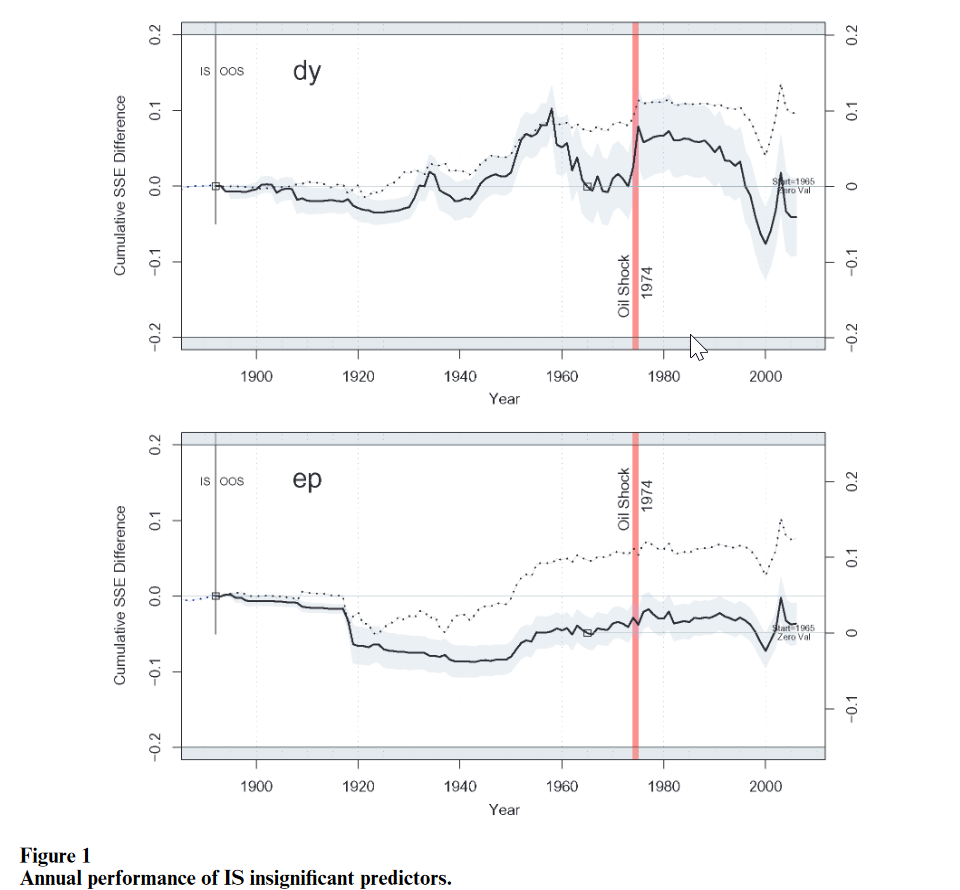

In [2]:
#hide 
display(Image("images/gw_1.png", width=500))

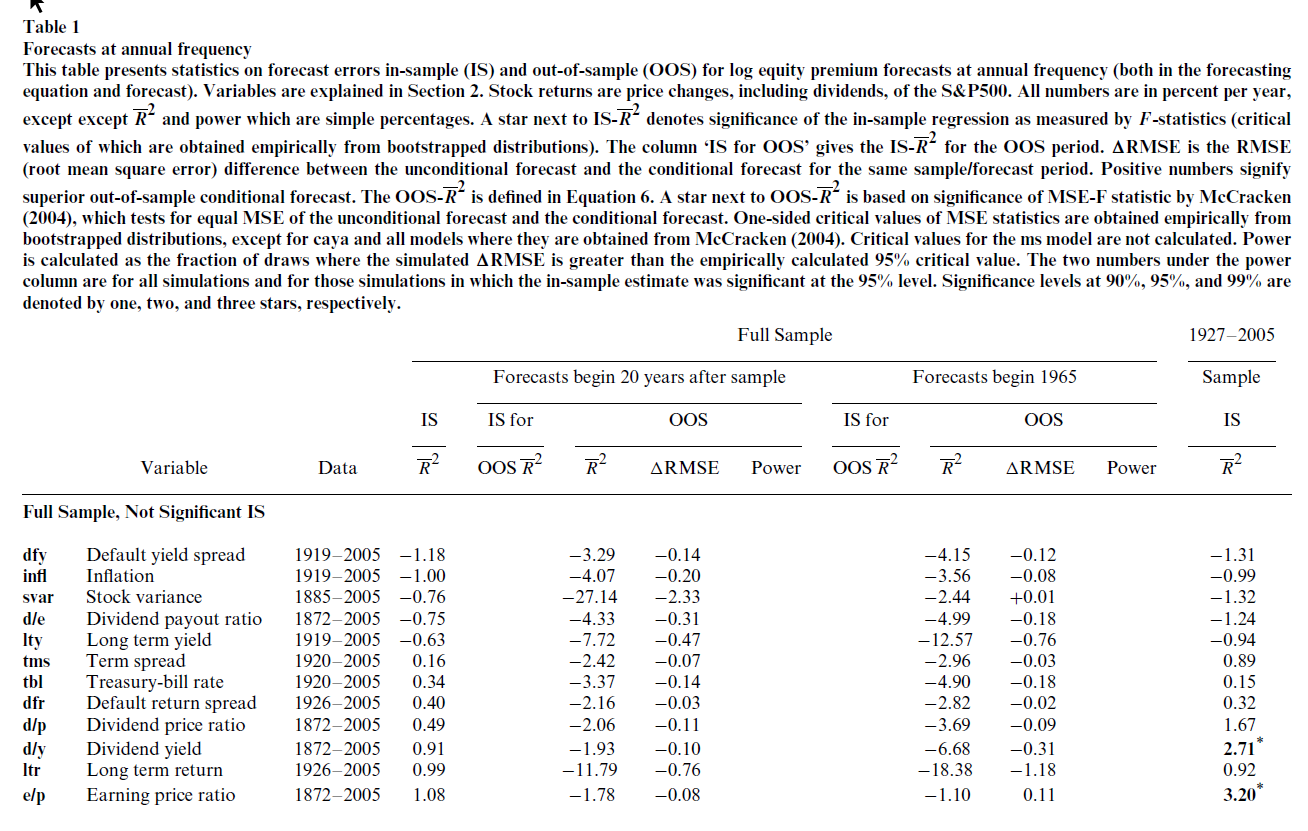

In [3]:
#hide 
display(Image("images/gw_2.png",width=700))

Welch-Goyal summary: very little predictability and the oil shock 1974 important in explaining results in the literature.

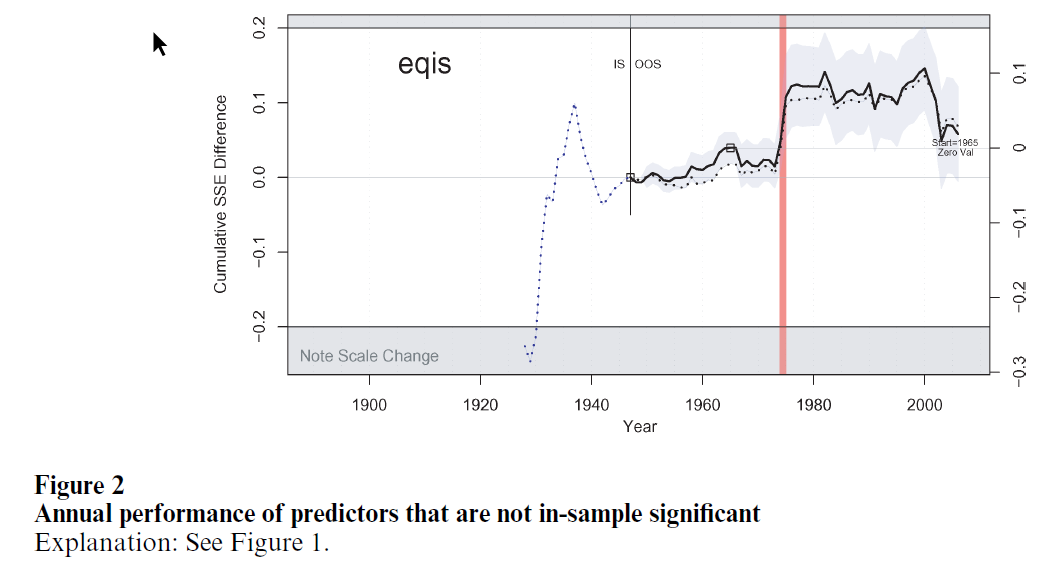

In [4]:
#hide 
display(Image("images/gw_3.png", width=500))

Campbell-Thompson: impose “sign-restrictions"

-  “in practice, an investor would not use a perverse coefficient but would likely conclude that the coefficient is zero, in effect imposing prior knowledge on the output of the regression" (p. 1516)

Sign restrictions

-  set the regression coefficient to zero whenever it has the "wrong" sign (different from the theoretically expected sign estimated over the sample)
- set the forecast equity premium to zero whenever it is negative

Summary: does dividend yield predict returns?

-  Yes: dividend yield is a strong predictor in the 1970s and 1980s (in-sample!)
-  No: the relationship became weaker in 1990s
- No: the statistical evidence is much weaker when adjusting for fact that regressors highly persistent
- No: dividend yield is also weak predictor out-of-sample –and rarely better than a moving-average.

Ways to improve predictability
- Impose restrictions on coefficients (Campbell and Thompson, 2005)

## Data

The data provided by Amit Goyal on the S\&P 500 is essentially identical to the one provided by Ken French.

In [5]:
from skfin.datasets import load_ag_features, load_kf_returns
df =  load_ag_features()[:'1999']

Annual
Monthly
Quarterly


In [6]:
ret = load_kf_returns(filename='F-F_Research_Data_Factors')['Monthly'][:'1999']

INFO:skfin.datasets:logging from cache directory: /home/schamponn/dev/projects/skfin/nbs/data/F-F_Research_Data_Factors


In [7]:
corr_ = df[['CRSP_SPvw']].corrwith(ret.assign(Mkt = lambda x: x['Mkt-RF'] + x['RF'])['Mkt'])['CRSP_SPvw']
print(f'Correlation data Ken French/Amit Goyal:{corr_:.2f}')

Correlation data Ken French/Amit Goyal:0.99


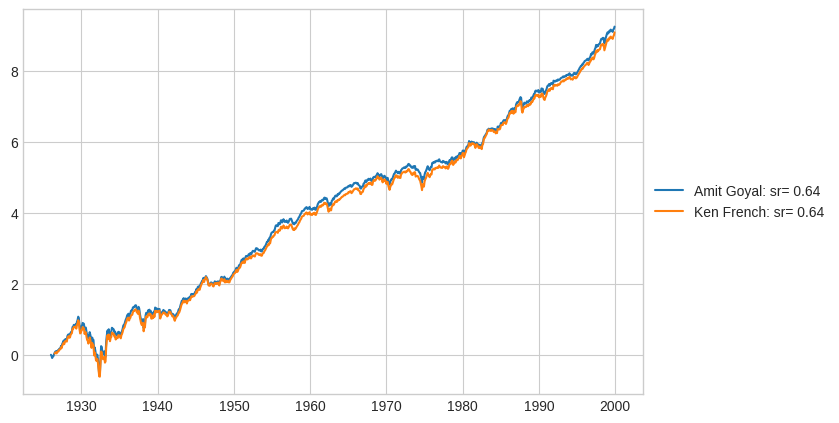

In [8]:
line({'Amit Goyal': df['CRSP_SPvw'], 'Ken French': ret.assign(Mkt = lambda x: x['Mkt-RF'] + x['RF'])['Mkt']/100}, cumsum=True)

## Timing backtest

In [9]:
from skfin.estimators import Ridge, RidgeCV
from skfin.mv_estimators import TimingMeanVariance

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [10]:
start_date = "1945-01-01"
test_size = 1
params = dict(max_train_size=36, test_size=test_size, gap=0)
params["n_splits"] = 1 + len(ret[:'1999'].loc[start_date:]) // test_size

cv = TimeSeriesSplit(**params)

In [11]:
cols = ['D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty', 'ntis', 'Rfree',
       'infl', 'ltr', 'corpr', 'svar', 'csp']
ret_ = ret['Mkt-RF']
target = ret_.values
features = df.loc[ret.index, cols].fillna(0).values

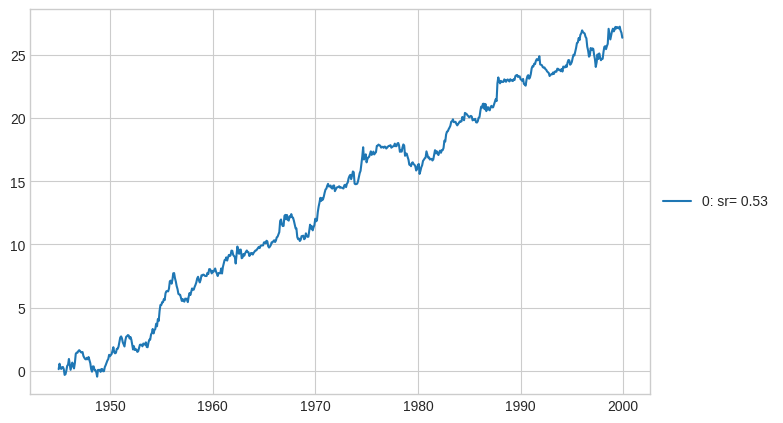

In [12]:
m = make_pipeline(StandardScaler(), 
                  Ridge(), 
                  TimingMeanVariance(a_min=-.25, a_max=.25))

_h = []
for train, test in cv.split(ret): 
    m.fit(features[train], target[train])
    _h += [m.predict(features[test])]
    
idx = ret.index[np.concatenate([test for _, test in cv.split(ret)])]
h = pd.Series(np.concatenate(_h), index=idx)
pnl = h.shift(1).mul(ret_).dropna()
line(pnl, cumsum=True)

We can plot the holdings and in this case, we see that the positions vary significantly and that there is a significant positive `tilt` (defined as the exponential average over the positions with a 252-day halflife). 

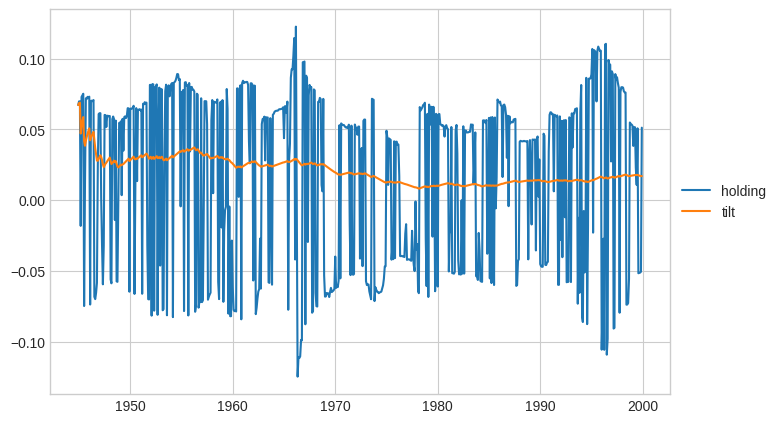

In [13]:
line({'holding': h, 'tilt': h.ewm(halflife=252).mean()})

Decomposing the pnl attributed to the `tilt` and the `timing` (defined as the difference between the positions and the `tilt`), we see that both contribute -- although the `timing` pnl has a lower sharpe ratio. 

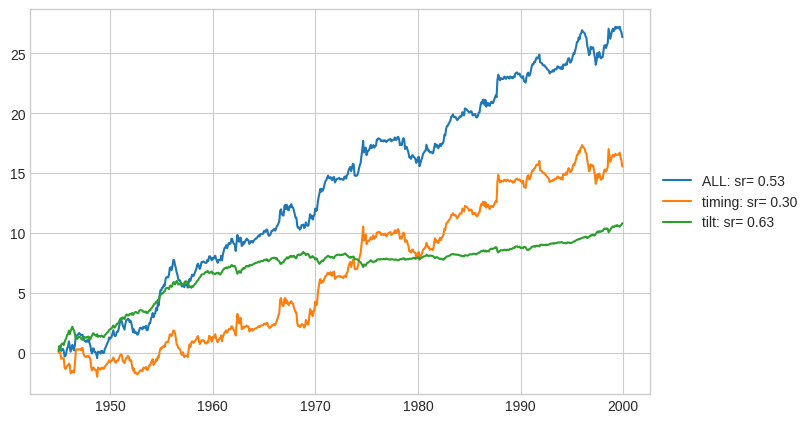

In [14]:
line({'ALL': pnl, 
      'tilt': h.ewm(halflife=252).mean().shift(1).mul(ret_).dropna(), 
      'timing': h.sub(h.ewm(halflife=252).mean()).shift(1).mul(ret_).dropna()}, cumsum=True)

In what follows, we use the `Backtester` clas with the timing pipeline. 

In [15]:
from skfin.backtesting import Backtester
estimator = make_pipeline(StandardScaler(), 
                          Ridge(), 
                          TimingMeanVariance(a_min=-.25, a_max=.25))

m = Backtester(estimator=estimator, ret=ret_)
m.train(features, target)

h.equals(m.h_), pnl.equals(m.pnl_)

(True, True)

## Other timing backtest statistics

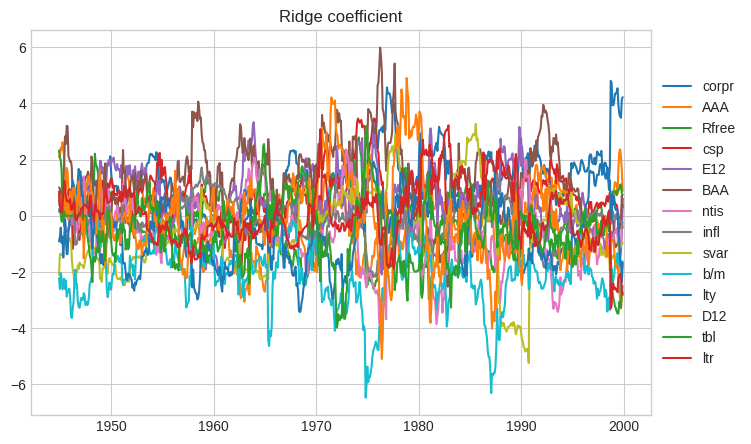

In [16]:
coef = pd.DataFrame([m_.steps[1][1].coef_ for m_ in m.estimators_], columns=cols, index=m.h_.index)
line(coef, title='Ridge coefficient')

In [17]:
from skfin.metrics import sharpe_ratio

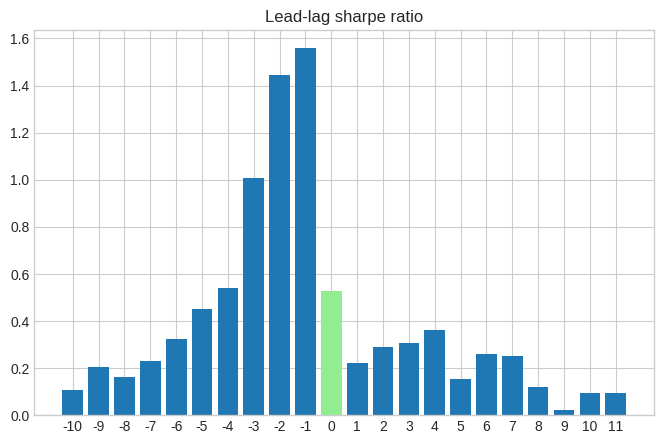

In [18]:
sr = {i: m.h_.shift(1+i).mul(ret_).pipe(sharpe_ratio) for i in range(-10, 12)}
bar(sr, baseline=0, sort=False, title='Lead-lag sharpe ratio')

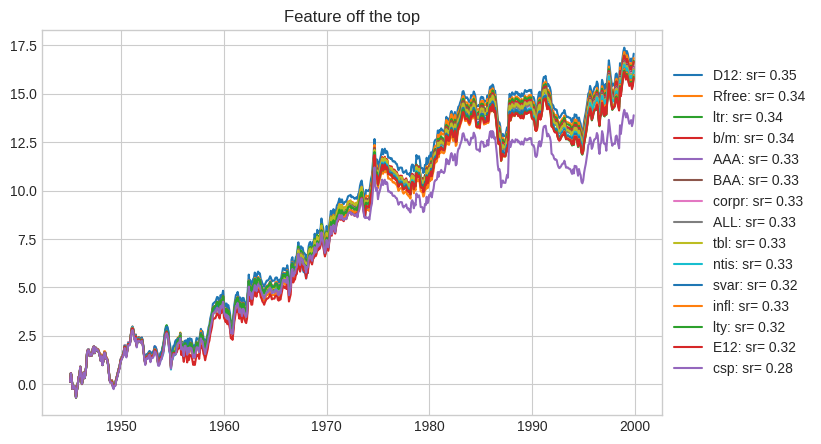

In [19]:
pnls_ = {}
for c in cols + ['ALL']:
    features_ = df.loc[ret.index].drop(c, axis=1, errors='ignore').fillna(0).values
    pnls_[c] = Backtester(estimator=estimator, ret=ret_).train(features_, target).pnl_
line(pnls_, cumsum=True, title='Feature off the top')

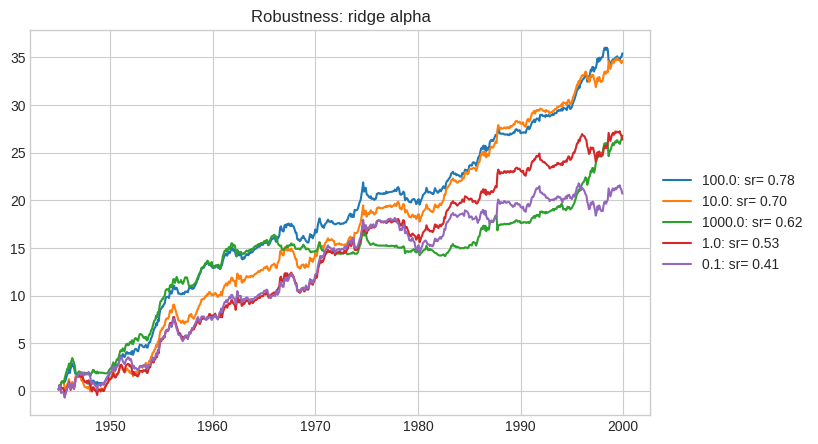

In [20]:
pnls_ = {}
for alpha in [.1, 1, 10, 100, 1000]: 
    estimator_ = make_pipeline(StandardScaler(), 
                              Ridge(alpha=alpha), 
                              TimingMeanVariance(a_min=-.25, a_max=.25))
    pnls_[alpha] = Backtester(estimator=estimator_, ret=ret_).train(features, target).pnl_
line(pnls_, cumsum=True, title='Robustness: ridge alpha')

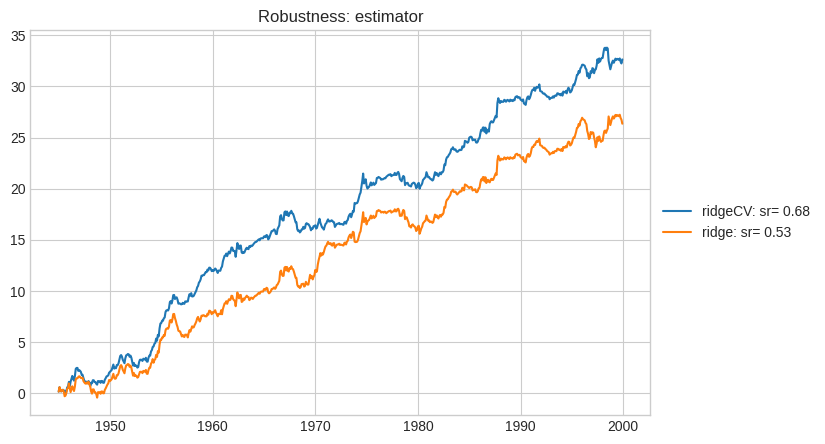

In [21]:
estimator_ = make_pipeline(StandardScaler(), 
                          RidgeCV(alphas=[1, 10, 100, 1000]), 
                          TimingMeanVariance(a_min=-.25, a_max=.25))

m_ = Backtester(estimator=estimator_, ret=ret_)
m_.train(features, target)
line({'ridge': m.pnl_, 'ridgeCV': m_.pnl_}, cumsum=True, title='Robustness: estimator')

The following graph shows the regularization paramter `alpha` estimated by cross-validation by the `RidgeCV` estimator. 

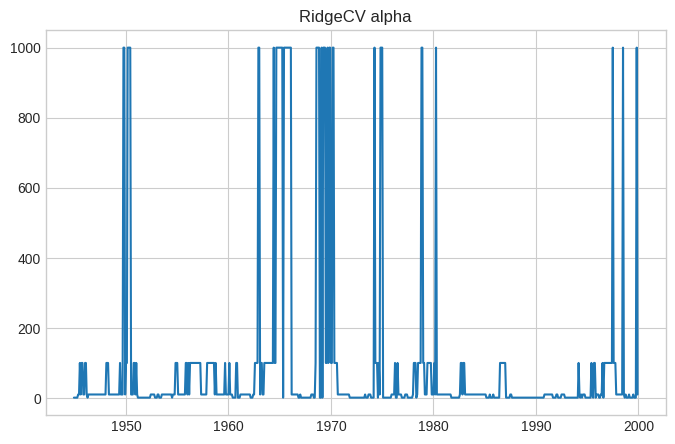

In [22]:
alpha = pd.Series([m_.steps[1][1].alpha_ for m_ in m_.estimators_],  index=m_.h_.index)
line(alpha, legend=False, title='RidgeCV alpha')